# Graph Anomaly Detection


## Loading and preparing the data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pickle as pkl

In [2]:
# Read files
path = "./dades_marti/"
df_classes = pd.read_csv(path + "elliptic_txs_classes.csv") # Nodes' labels
df_edges = pd.read_csv(path + "elliptic_txs_edgelist.csv") # Edges
df_features = pd.read_csv(path + "elliptic_txs_features.csv", header=None) # Nodes' features

In [3]:
# Change column names of df_features
colNames1 = {'0': 'txId', 1: "Time Step"}
colNames2 = {str(ii+2): "Local_feature_" + str(ii+1) for ii in range(93)}
colNames3 = {str(ii+95): "Aggregate_feature_" + str(ii+1) for ii in range(72)}

colNames = dict(colNames1, **colNames2, **colNames3 )
colNames = {int(jj): item_kk for jj,item_kk in colNames.items()}

df_features = df_features.rename(columns=colNames)

In [4]:
# Pass unknown to number -1, 1 ilicit, 0 licit
df_classes.loc[df_classes['class'] == 'unknown', 'class'] = -1
df_classes.loc[df_classes['class'] == '2', 'class'] = 0
df_classes.loc[df_classes['class'] == '1', 'class'] = 1

# Time step now starts at 0
df_features['Time Step'] -= 1

print('Shape of classes', df_classes.shape)
print('Shape of edges', df_edges.shape)
print('Shape of features', df_features.shape)

Shape of classes (203769, 2)
Shape of edges (234355, 2)
Shape of features (203769, 167)


In [5]:
# Merge Class and features
df_class_feature = pd.merge(df_classes, df_features)
# df_class_feature.head()
df = df_class_feature
del df_class_feature
df.head()

,txId,class,Time Step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,...,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72
0,230425980,-1,0,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,-1,0,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,-1,0,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,0,0,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,-1,0,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


## Single out a time step and work with

#### Study timestep properties

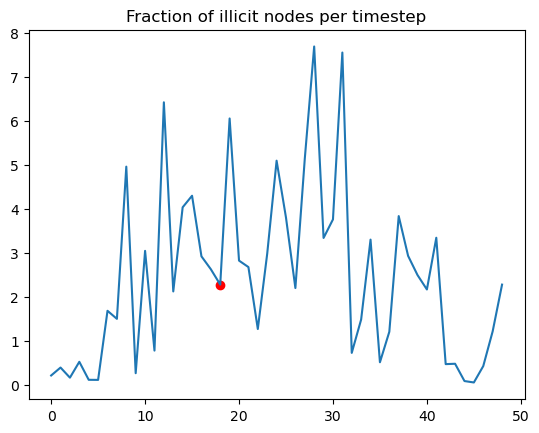

Median proportion highlighted in red


In [6]:
# Illicit node proportion

proportions = []
for i in range(0, 49):
    class_vector = df[df['Time Step'] == i]['class']
    illicit_count = len([classe for classe in class_vector if classe == 1])
    proportions.append(100*illicit_count / len(class_vector))

# Get the index of the median
median_index = np.argsort(proportions)[len(proportions)//2]

# Plot the proportions of illicit nodes
plt.plot(proportions)
plt.scatter(median_index, proportions[median_index], color='red')
plt.title('Fraction of illicit nodes per timestep')
plt.show()

print('Median proportion highlighted in red')

#### Study timestep 18

I picked 18 because it's the median proportion but it's pretty arbitrary; it doesn't matter.

In [7]:
# Separate this timestep's rows from the df's
df18 = df[df['Time Step'] == 18]
df18_edges = df_edges[df_edges['txId1'].isin(df18['txId']) & df_edges['txId2'].isin(df18['txId'])]

len(df18), len(df18_edges)

(3506, 3838)

In [8]:
# Create graph from the df of edges
edgelist = [(r['txId1'], r['txId2']) for i, r in df18_edges.iterrows()]
G18 = nx.Graph(edgelist)

G18.order(), G18.size()

(3506, 3838)

In [9]:
# Data
print("Nº of illicit nodes:", len(df18[df18['class'] == 1]))
print("Nº of licit nodes:", len(df18[df18['class'] == 0]))
print("Nº of unknown nodes:", len(df18[df18['class'] == -1]))

Nº of illicit nodes: 80
Nº of licit nodes: 665
Nº of unknown nodes: 2761


#### What can we do with time step 18?

In [10]:
# node2vec embeddings?
from node2vec import Node2Vec
import tqdm as notebook_tqdm
from gensim.models import Word2Vec

node2vec = Node2Vec(G18, dimensions=3, walk_length=20, num_walks=200, p=2, q=1, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

model.save("./dades_marti/node2vec_ts18.bin")

Computing transition probabilities:   0%|          | 0/3506 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:40<00:00,  4.97it/s]


In [16]:
model = Word2Vec.load('dades_marti/node2vec_ts18.bin')

# Access the embedding weights
embeddings = model.wv.vectors

# Check the shape of the embedding matrix
print("Shape of embedding matrix:", embeddings.shape)

Shape of embedding matrix: (3506, 3)


In [48]:
np.shape(embeddings)

(3506, 3)

In [49]:
a = np.array([0,2,4,6,1,4])
b = [0,1,2]
a[b]

array([0, 2, 4])

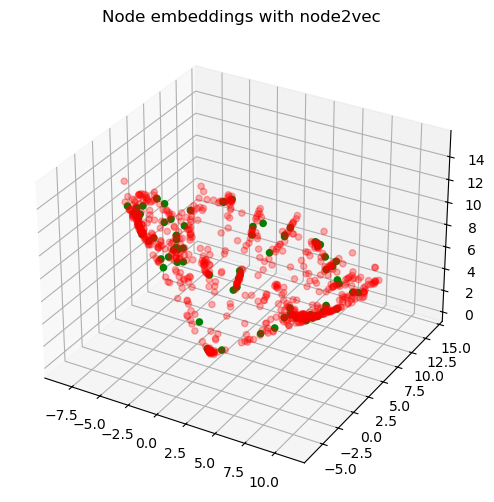

In [62]:
# Plot 3D embeddings

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

# Color code by classes
colours = ['yellow', 'red', 'green']
alphas = [0, 0.3, 1]

for label in np.unique(df18['class']):
    indices = np.where(df18['class'] == label)
    ax.scatter(embeddings[indices, 0],
               embeddings[indices, 1],
               embeddings[indices, 2],
               c=colours[label+1],
               label=f'Class {label}',
               alpha=alphas[label+1])
    
plt.title("Node embeddings with node2vec")
plt.show()

# Una altra opcio es tsne, per reduir dimensionalitat i plotejar


In [27]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [28]:
# Cluster-then label

df18_ml = df18.drop(columns=['txId', 'class', 'Time Step'])

X_train, X_test, y_train, y_test = train_test_split(df18_ml, df18['class'])

In [41]:
class Cluster_Then_Label():
    def __init__(self, df, classes):
        self.X = df
        self.y = classes
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X,
                                                                                self.y,
                                                                                test_size=0.2)
        self.kmeans = None
        
    def run_kmeans(self):
        self.kmeans = KMeans(verbose=0).fit(self.X)
    
    def pseudo_label(self):
        for 
    
    def iterate(self, n_iters=5):
        ...

    def test(self):
        ...


In [ ]:
ctl = Cluster_Then_Label(df18_ml, df18['class'])
ctl.run_kmeans()

In [46]:
from collections import Counter

def purity_score(y_true, y_pred):
    # Assign cluster labels to each data point
    cluster_labels = np.unique(y_pred)
    purity = 0
    
    # For each cluster label
    for cluster_label in cluster_labels:
        # Get the indices of data points in the cluster
        indices = np.where(y_pred == cluster_label)[0]
        # Get the ground truth labels of these data points
        cluster_labels_true = y_true[indices]
        # Find the majority class in the cluster
        majority_class = Counter(cluster_labels_true).most_common(1)[0][1]
        # Add the size of the majority class to purity
        purity += majority_class
    # Normalize purity
    purity /= len(y_pred)
    return purity

y_true = df18['class']
y_pred = ctl.kmeans.labels_
purity = purity_score(y_true, y_pred)
print("Purity:", purity)


KeyError: "None of [Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,\n       ...\n       3494, 3495, 3498, 3499, 3500, 3501, 3502, 3503, 3504, 3505],\n      dtype='int64', length=2750)] are in the [index]"